In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
#import xgboost as xgb
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, auc,roc_auc_score
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('standerdize.csv', delimiter=",")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256294 entries, 0 to 256293
Data columns (total 34 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   payerAccountNumber            256294 non-null  float64
 1   payerIdTransformed            256294 non-null  float64
 2   payeeIdTransformed            256294 non-null  float64
 3   originalAmount                256294 non-null  float64
 4   createdAt                     256294 non-null  float64
 5   transaction_date              256294 non-null  float64
 6   transaction_time              256294 non-null  float64
 7   issuer_bank                   256294 non-null  float64
 8   ip_address                    256294 non-null  float64
 9   browser                       256294 non-null  float64
 10  funding_method                256294 non-null  int64  
 11  secure_3ds                    256294 non-null  int64  
 12  success_3ds                   256294 non-nul

In [3]:
X = df.drop(['is_fraud'],axis=1)
y = df.is_fraud

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)
#strategy = {1:10000}
#oversample = SMOTE()
#X_oversample, y_oversample = oversample.fit_resample(X_train, y_train)


In [4]:
models = []
#models.append(("LR",LogisticRegression()))
models.append(("RF",RandomForestClassifier()))
models.append(("XGB",XGBClassifier(use_label_encoder=False,eval_metric='mlogloss')))

RandomForestClassifier


RF [0.99783731 0.99764777]
=== Mean Accuracy ===
Mean Accuracy Score -:  0.9977425373051462


=== Mean AUC Score ===
Mean AUC Score -:  0.9115569201979388


=== Confusion Matrix ===
[[76661    22]
 [  134    72]]




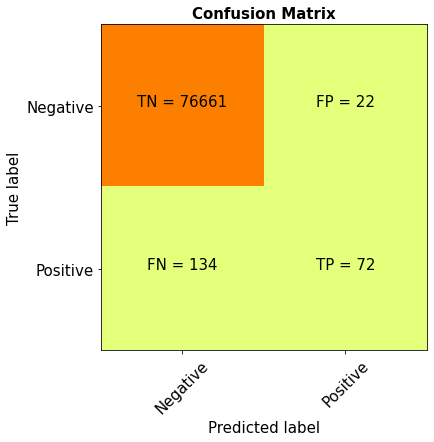

=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     76683
           1       0.77      0.35      0.48       206

    accuracy                           1.00     76889
   macro avg       0.88      0.67      0.74     76889
weighted avg       1.00      1.00      1.00     76889



                         feature  importance
4                      createdAt    0.179635
1             payerIdTransformed    0.161758
6               transaction_time    0.152709
2             payeeIdTransformed    0.119337
5               transaction_date    0.115355
3                 originalAmount    0.073971
0             payerAccountNumber    0.061788
7                    issuer_bank    0.039767
26                channel_master    0.008024
16                   amount_high    0.006142
25                  channel_visa    0.005942
22        bank_insufficient_fund    0.005816
31           initialized_ext_api    0.005735
10         

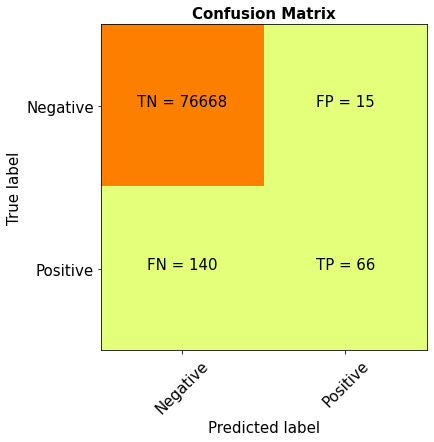

=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     76683
           1       0.81      0.32      0.46       206

    accuracy                           1.00     76889
   macro avg       0.91      0.66      0.73     76889
weighted avg       1.00      1.00      1.00     76889



                         feature  importance
28               initialized_api    0.247305
2             payeeIdTransformed    0.159108
11                    secure_3ds    0.121594
14                          type    0.084437
31           initialized_ext_api    0.056068
19                 bank_approved    0.036159
18  high_risk_credit_transaction    0.025143
1             payerIdTransformed    0.020789
7                    issuer_bank    0.019747
10                funding_method    0.018610
22        bank_insufficient_fund    0.018586
23             bank_do_not_honor    0.018428
3                 originalAmount    0.017425
29         

In [5]:
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])
for name,model in models:
    kfold = KFold(n_splits=2, random_state=22,shuffle=True)
    cv_result = cross_val_score(model, X_train, y_train, cv = kfold, scoring = "accuracy")
    roc_auc_result = cross_val_score(model, X_train, y_train, cv = kfold, scoring = "roc_auc")
    print(model.__class__.__name__,)
    print('\n')
    print(name, cv_result)
    print("=== Mean Accuracy ===")
    print("Mean Accuracy Score -: ", cv_result.mean())
    print('\n')
    print("=== Mean AUC Score ===")
    print("Mean AUC Score -: ", roc_auc_result.mean())
    print('\n')
    model.fit(X_train, y_train)
    # predictions
    actual=y_test
    predict = model.predict(X_test)
    
    print("=== Confusion Matrix ===")
    cm = confusion_matrix(actual,predict)
    print(cm)
    print('\n')
    
    plt.figure(figsize=(8,6))
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Negative','Positive']
    plt.title('Confusion Matrix',fontsize=15,fontweight='bold')
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45,fontsize=15)
    plt.yticks(tick_marks, classNames,fontsize=15)
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]),horizontalalignment="center",fontsize=15)
    plt.show()
    
    print("=== Classification Report ===")
    print(classification_report(actual,predict))
    print('\n')
    
    importances=model.feature_importances_
    fi = pd.DataFrame({'feature': list(X_train.columns),
                   'importance': model.feature_importances_}).sort_values('importance', ascending = False)

    # Display
    print(fi)
    
      # Probabilities for each class
    probs = model.predict_proba(X_test)[:, 1]
     #auc = roc_auc_score(y_test, yproba)
    fpr, tpr, thresholds = roc_curve(actual,  predict)
    roc_auc = auc(fpr, tpr)
    result_table = result_table.append({'classifiers':"original - "+model.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':roc_auc}, ignore_index=True)
#result_table.set_index('classifiers', inplace=True)

In [6]:
featuer_engineering_df = pd.read_csv('feature_engineering_filtered_standerdize.csv', delimiter=",")

In [7]:
X_featured = featuer_engineering_df.drop(['is_fraud'],axis=1)
y_featured = featuer_engineering_df.is_fraud

X_train_featured, X_test_featured, y_train_featured, y_test_featured = train_test_split(X_featured, y_featured, test_size=0.3, random_state=22)

RandomForestClassifier


RF [0.99773698 0.99749169]
=== Mean Accuracy ===
Mean Accuracy Score -:  0.9976143355946553


=== Mean AUC Score ===
Mean AUC Score -:  0.9325526598644293


=== Confusion Matrix ===
[[76632    51]
 [  108    98]]




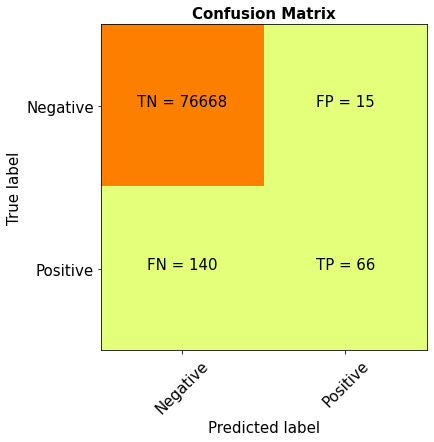

=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     76683
           1       0.66      0.48      0.55       206

    accuracy                           1.00     76889
   macro avg       0.83      0.74      0.78     76889
weighted avg       1.00      1.00      1.00     76889



                                     feature    importance
4                                  createdAt  1.823576e-01
6                           transaction_time  1.545986e-01
5                           transaction_date  1.199922e-01
1                         payerIdTransformed  1.081785e-01
2                         payeeIdTransformed  1.041530e-01
3                             originalAmount  4.881028e-02
0                         payerAccountNumber  1.773918e-02
7                                issuer_bank  1.686413e-02
27                               total_value  1.235858e-02
25                                   recency  1.083

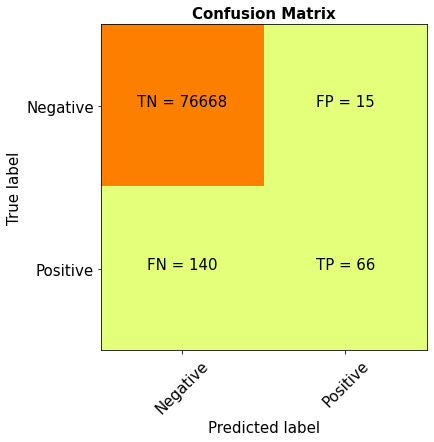

=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     76683
           1       0.69      0.35      0.46       206

    accuracy                           1.00     76889
   macro avg       0.85      0.67      0.73     76889
weighted avg       1.00      1.00      1.00     76889



                                     feature  importance
2                         payeeIdTransformed    0.106889
69                 m_tot_suspiciout_tm_trans    0.099818
37                   tot_suspiciout_tm_trans    0.084497
66                          m_one_time_count    0.046614
34                            one_time_count    0.042391
56     sus_attempts_perday_test_transactions    0.033759
38                tot_high_risk_credit_trans    0.031239
40                              tot_bank_err    0.027815
52                   suspecious_credit_trans    0.022863
70              m_tot_high_risk_credit_trans    0.019287
49            

In [8]:
for name,model in models:
    kfold = KFold(n_splits=2, random_state=22,shuffle=True)
    cv_result = cross_val_score(model, X_train_featured, y_train_featured, cv = kfold, scoring = "accuracy")
    roc_auc_result = cross_val_score(model, X_train_featured, y_train_featured, cv = kfold, scoring = "roc_auc")
    print(model.__class__.__name__,)
    print('\n')
    print(name, cv_result)
    print("=== Mean Accuracy ===")
    print("Mean Accuracy Score -: ", cv_result.mean())
    print('\n')
    print("=== Mean AUC Score ===")
    print("Mean AUC Score -: ", roc_auc_result.mean())
    print('\n')
    model.fit(X_train_featured, y_train_featured)
    # predictions
    actual=y_test_featured
    predict = model.predict(X_test_featured)
    
    print("=== Confusion Matrix ===")
    print(confusion_matrix(actual,predict))
    print('\n')
    
    plt.figure(figsize=(8,6))
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Negative','Positive']
    plt.title('Confusion Matrix',fontsize=15,fontweight='bold')
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45,fontsize=15)
    plt.yticks(tick_marks, classNames,fontsize=15)
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]),horizontalalignment="center",fontsize=15)
    plt.show()
    
    print("=== Classification Report ===")
    print(classification_report(actual,predict))
    print('\n')
    
    fi_featured = pd.DataFrame({'feature': list(X_train_featured.columns),
                   'importance': model.feature_importances_}).sort_values('importance', ascending = False)
    pd.set_option('display.max_rows', None)
    # Display
    print(fi_featured)
    
    # Probabilities for each class
    probs = model.predict_proba(X_test_featured)[:, 1]
     #auc = roc_auc_score(y_test, yproba)
    fpr_featured, tpr_featured, thresholds = roc_curve(actual,  predict)
    roc_auc_featured = auc(fpr_featured, tpr_featured)

    
    result_table = result_table.append({'classifiers':"featured - "+model.__class__.__name__,
                                        'fpr':fpr_featured, 
                                        'tpr':tpr_featured, 
                                        'auc':roc_auc_featured}, ignore_index=True)
result_table.set_index('classifiers', inplace=True)

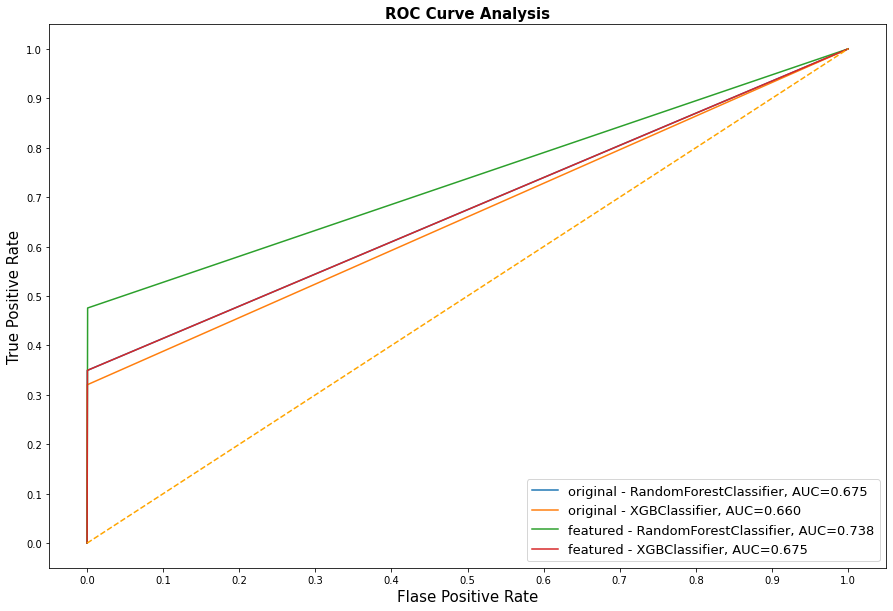

In [9]:
fig = plt.figure(figsize=(15,10))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

In [10]:
fig.savefig('multiple_roc_curve.png')

In [16]:
featuer_engineering_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256294 entries, 0 to 256293
Columns: 154 entries, payerAccountNumber to final_critical_index
dtypes: float64(101), int64(52), object(1)
memory usage: 301.1+ MB
